In [1]:
import sympy as sym  # библиотека символьных вычислений
import numpy as np # библиотека для работы с массивами
import math  # для операции факториала, числа pi
import matplotlib.pyplot as plt  # для построения графиков

In [2]:
x = sym.symbols('x')  # инициализировали символьные переменные
f = sym.Function('f')(x)  # инициализировали символьную функцию
# N = 1 - номер в списке группы
f = x - sym.sin(x) - 0.25  # определили функцию соответственно номеру в списке группы
a = 0
b = 10  # [a,b] - выбранный интервал интерполирования 

# Функции построения полинома Лагранжа и сплайна S_32

In [3]:
def get_knots(n, which):
    knots = []  
    if which == 'equidistant':  # равноотстоящие узлы интерполирования
        for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    elif which == 'optimal':  # оптимальные узлы интерполирования
        knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) 
    return knots

In [4]:
def Ln(n, f, which):
    knots = get_knots(n, which)
    # строим полином Лагранжа
    L_n = 0
    for xi in knots:
        knots_wo_xi = knots.copy()
        knots_wo_xi.remove(xi)  # запомнили в переменную элементы knots кроме xi
        numerator_lk = 1  # строим l_k(x)
        denumerator_lk = 1
        for xk in knots_wo_xi:
            numerator_lk = numerator_lk*(x-xk)
            denumerator_lk = denumerator_lk*(xi-xk)
        l_k = numerator_lk/denumerator_lk
        L_n += l_k*f.subs(x, xi)  # полином Лагранжа
    return L_n
def RL(n, f, which):
    L_n = Ln(n, f, which)
    m = 20*n
    T = get_knots(m, 'equidistant')  # массив точек разбиения [a,b], в которых определяется отклонение 
    r = [abs(f.subs(x, ti) - L_n.subs(x, ti)) for ti in T]  # массив отклонений ИПЛ в точках T
    return T, r

In [5]:
def Gauss(A, b): # A - матрица (n,n), b - вектор (n,1)
    n=len(b)
    #прямой ход метода Гаусса
    for k in range(n): # строки
        # поиск максимума по столбцу
        max_index=0 # индекс максимума к-го столбца
        maxk=0  # максимум к-го столбца
        for i in range(k, n): # столбцы
            if (maxk<abs(A[i][k])):
                    max_index=i
                    maxk=abs(A[i][k])
        #нашли индекс максимума, теперь меняем строки
        Cb=b[k]
        b[k]=b[max_index]
        b[max_index]=Cb
        
        C=A[k]
        A[k]=A[max_index]
        A[max_index]=C  
        #
        # нормируем строку
        b[k]=b[k]/A[k][k]
        A[k]=[A[k][x]/A[k][k] for x in range(n)] 
        # преобразуем последующие n-k строк
        for m in range(k+1, n):
            b[m]=b[m]-b[k]*A[m][k]
            A[m]=[A[m][x]-A[k][x]*A[m][k] for x in range(n)]            
        #
    #print('A=', np.array(A).round(4))
    #print('b=', np.array(b).round(4))
    
    # обратный ход метода Гаусса
    X=[0]*n # вектор неизвестных
    i=n
    while (i!=0):
        i-=1
        X[i]=b[i]
        for j in range(n-i-1):
            X[i]=X[i]-A[i][n-1-j]*X[i+1]
    return X


In [6]:
def S_32(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)
    knots = list((b-a)/(n+1)*(i+1) for i in range(n))
    h = (b-a)/n  # т.к. равноотстоящие узлы
    
    # строим матрицу H, векторы y_1, y_2
    # где y_1 - вектор первых производных, y_2 - вектор вторых производных на отрезках интерполирования
    H = np.eye(n-2)*4*h
    for i in range(1, n-2):
        H[i][i-1] = h  # заполнили H, (h одно и то же) по формуле 5.2.24
        H[i-1][i] = h
    # заполним вектор гамма по формуле 5.2.23
    gamma = np.zeros(n-2)
    for i in range(1, n-1):
        gamma[i-1] = 6/h*(f.subs(x,knots[i+1])-2*f.subs(x,knots[i])+f.subs(x,knots[i-1]))
    # вычисляем вектор у_2
    y_2 = Gauss(H, gamma)  # решаем СЛАУ H*y_2=gamma методом Гаусса
    y_2 = np.append(0, y_2)  # y_2[0] = y_2[n-1] = 0 по условию
    y_2 = np.append(y_2, 0)
    # вычисляем вектор y_1 по формуле 5.2.25
    y_1 = np.zeros(n-1)
    for i in range(n-1):
        y_1[i] = (f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h - y_2[i+1]*h/6 - y_2[i]*h/3
    # C - массив коэффициентов полиномов 
    C = np.zeros(4*(n-1))
    for i in range(n-1):
        Ci = sym.Function('Ci')(x)
        # Ci - полином на каждом отрезке разбиения, вычисляем по формуле 5.2.26
        Ci = (f.subs(x, knots[i]) + y_1[i]*(x-knots[i]) + y_2[i]*(x-knots[i])**2/2 + (y_2[i+1]-y_2[i])*(x-knots[i])**3/(6*h))
        coeffs = sym.poly(Ci).coeffs()  # вычленили коэффициенты полинома Ci
        for j in range(4):
            C[4*i+j] = coeffs[j]  # записали коэффициенты полинома Ci в общий вектор коэффициентов
    return C
def RS(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    ans = S_32(n, f)  # сплайн 3,2, вектор коэффициентов
    m = 20*n  # количество точек разбиения
    r = []  # массив максимумов отклонений сплайна на отрезках [x_j,x_j+1]
    X = []
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[4*j]*x**3 + ans[4*j+1]*x**2+ans[4*j+2]*x+ans[4*j+3]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        for rjk in rj:
            r.append(rjk)
        for t in T:
            X.append(t)
    return X, r

In [7]:
def S_32opt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()  # отсортировала, т.к. для вычисления h надо чтобы узлы были последовательно в массиве
    h = [knots[i]-knots[i-1] for i in range(1, n)] # вектор разностей (расстояний) между узлами
    
    # строим матрицу H, векторы у_1, y_2
    # где y_1 - вектор первых производных, y_2 - вектор вторых производных 
    H = np.eye(n-2)  # пока задали единичную матрицу
    for i in range(1, n-2):
        H[i-1][i-1]=2*(h[i-1]+h[i])  # заполняем H по формуле 5.2.24
        H[i][i-1] = h[i]
        H[i-1][i] = h[i]
    H[n-3][n-3] = 2*(h[n-3]+h[n-2])
    # заполним вектор гамма по формуле 5.2.23
    gamma = np.zeros(n-2)
    for i in range(1, n-1):
        gamma[i-1] = 6*((f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h[i] - (f.subs(x,knots[i])-f.subs(x,knots[i-1]))/h[i-1])
    # вычислим вектор y_2
    y_2 = Gauss(H, gamma)  # решаем СЛАУ H*y_2=gamma методом Гаусса
    y_2 = np.append(0, y_2)  # y_2[0] = y_2[n-1] = 0 по условию
    y_2 = np.append(y_2, 0)
    # вычислим вектор y_1 по формуле 5.2.25
    y_1 = np.zeros(n-1)
    for i in range(n-1):
        y_1[i] = (f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h[i] - y_2[i+1]*h[i]/6 - y_2[i]*h[i]/3
    # C - массив коэффициентов полиномов 
    C = np.zeros(4*(n-1))
    for i in range(n-1):
        # Ci - полином на каждом отрезке разбиения, вычисляем по формуле 5.2.26
        Ci = sym.Function('Ci')(x)
        Ci = (f.subs(x, knots[i]) + y_1[i]*(x-knots[i]) + y_2[i]*(x-knots[i])**2/2 + (y_2[i+1]-y_2[i])*(x-knots[i])**3/(6*h[i]))
        coeffs = sym.poly(Ci).coeffs()  # вычленили коэффициенты полинома Ci
        for j in range(4):
            C[4*i+j] = coeffs[j]  # записали коэффициенты полинома Ci в общий вектор коэффициентов
    return C
def RSopt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    ans = S_32opt(n, f) 
    m = 20*n
    X = []
    r = []  # массив отклонений ИПЛ в точках T
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[4*j]*x**3 + ans[4*j+1]*x**2+ans[4*j+2]*x+ans[4*j+3]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        for rjk in rj:
            r.append(rjk)
        for t in T:
            X.append(t)
    return X, r

# Построение графика распределения абсолютной погрешности

In [8]:
def plotting(n):
    X, r = RL(n, f, 'equidistant')
    plt.figure()
    plt.plot(X, r, '--', linewidth = 1)
    plt.title("распределение погрешности полинома Лагранжа на равноотстоящих узлах n={}".format(n))
    plt.figure()
    X, r = RL(n, f, 'optimal')
    plt.plot(X[n:], r[n:], '--', linewidth = 1)
    plt.title("распределение погрешности полинома Лагранжа на оптимальных узлах n={}".format(n))
    X, r = RS(n, f)
    plt.figure()
    plt.plot(X, r, '--', linewidth = 1)
    plt.title("распределение погрешности S_32 на равноотстоящих узлах n={}".format(n))
    plt.figure()
    X, r = RSopt(n, f)
    plt.plot(X, r, '--', linewidth = 1)
    plt.title("распределение погрешности S_32 на оптимальных узлах n={}".format(n))

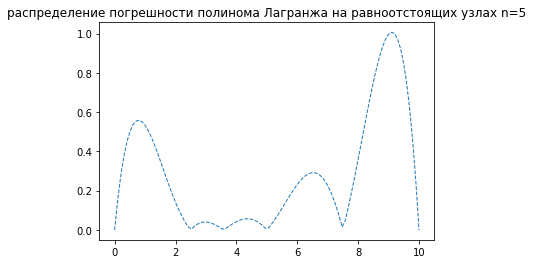

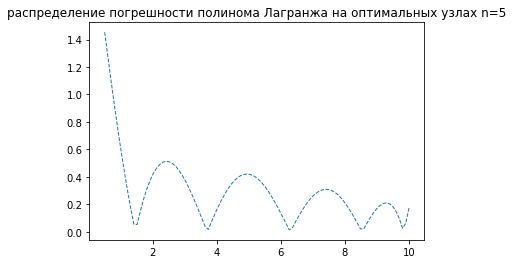

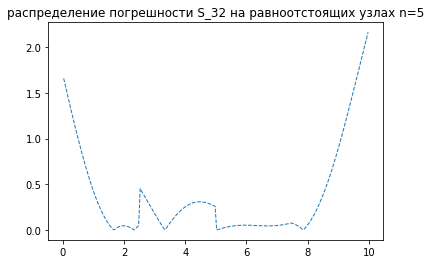

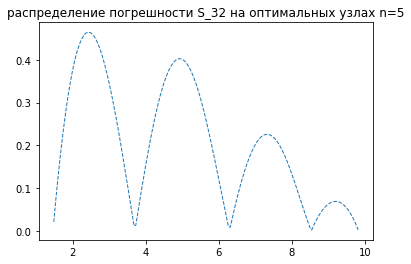

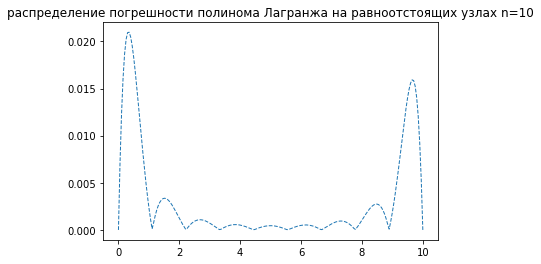

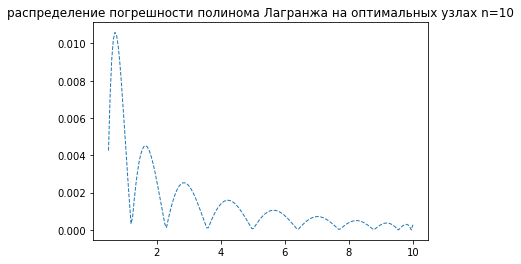

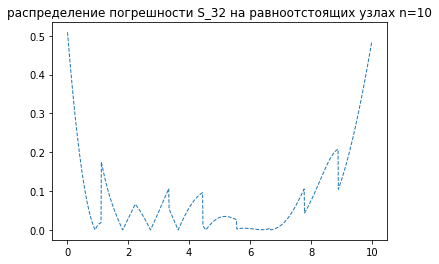

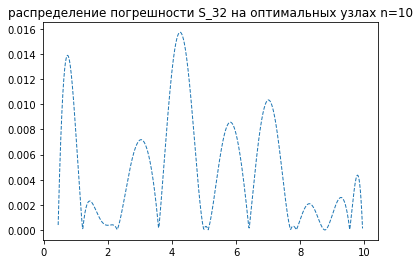

In [9]:
plotting(5)
plotting(10)